# 2D Gaussian Regression

2D Gaussian Regression is the next step.

In [1]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
train_x = torch.linspace(0,1,11)
train_y = torch.linspace(0,1,11)
grid_x, grid_y = torch.meshgrid(train_x, train_y)

In [19]:
def sinner(x, y):
    return torch.sin(2 * torch.Tensor([np.pi]) * x) + torch.cos(2 * torch.Tensor([np.pi]) * y)

In [20]:
train_z = sinner(grid_x, grid_y)

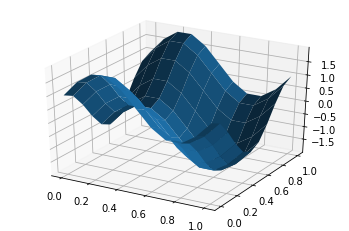

In [21]:
ax = plt.axes(projection='3d')
with torch.no_grad():
    
    ax.plot_surface(grid_x.numpy(), grid_y.numpy(), train_z.numpy())

In [22]:
class MyGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MyGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MyGPModel(train_x, train_y, likelihood)

In [23]:
# Create an ordered data set (X, Y) = ([1,1], 0)
train_x = torch.zeros(train_z.size(0) * train_z.size(1), 2)
train_y = torch.zeros(train_z.shape).reshape(-1)
for i in range(grid_x.size(0)):
    for j in range(grid_x.size(1)):
        train_x[i*grid_x.size(0) + j, 0] = grid_x[i, j]
        train_x[i*grid_x.size(0) + j, 1] = grid_y[i, j]
        train_y[i*grid_x.size(0) + j] = sinner(grid_x[i,j], grid_y[i,j])

In [24]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MyGPModel(train_x , train_y, likelihood)

In [25]:
train_x.shape, train_y.shape

(torch.Size([121, 2]), torch.Size([121]))

In [26]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.constant', tensor([0.])),
             ('base_kernel.raw_lengthscale', tensor([[0., 0.]])),
             ('base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0., 0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_

In [27]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in tqdm(range(500)):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

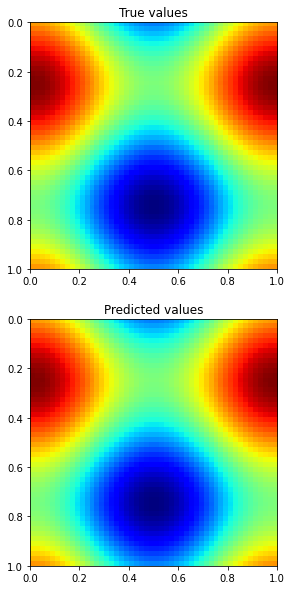

In [28]:
model.eval()
likelihood.eval()

# Initialize plots
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Test points
n1, n2 = 50, 50
xv, yv = torch.meshgrid([torch.linspace(0, 1, n1), torch.linspace(0, 1, n2)])
f = sinner(xv, yv)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    
extent = (xv.min(), xv.max(), yv.max(), yv.min())
ax[0].imshow(f, extent=extent, cmap=cm.jet)
ax[0].set_title('True values')

ax[1].imshow(mean[:].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1].set_title('Predicted values')

None